In [ ]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
os.listdir('/content/gdrive/MyDrive/study3_simpson')

['pix2pix.ipynb', 'simpson_prac.ipynb', 'cropped.zip', 'simplified.zip']

In [ ]:
!unzip -qq "/content/gdrive/MyDrive/study3_simpson/cropped.zip"

In [ ]:
!unzip -qq "/content/gdrive/MyDrive/study3_simpson/simplified.zip"

In [ ]:
cropped_lst = os.listdir('/content/cropped/cropped')
print(len(cropped_lst))
simplified_lst = os.listdir('/content/simplified/simplified')
print(len(simplified_lst))
print(cropped_lst[0])

8491
4099
7993.png


In [ ]:
os.listdir('/content/cropped/cropped')

In [ ]:
import cv2
a = cv2.imread('content/cropped/cropped/10.png',1)
print(a)

None


In [ ]:
#os.listdir('/content/cropped/cropped')

In [ ]:
# concat image

import cv2
import numpy as np

for img_num in cropped_lst: # img = 7993.png
  #print(img_num)

  if img_num in simplified_lst:
    img_gt = cv2.imread("/content/cropped/cropped/"+img_num, 1)
    img_input = cv2.imread("/content/simplified/simplified/"+img_num, 1)
    #print(img_gt.shape, img_input.shape)
    img_input = cv2.resize(img_input, (128,128))
    img_gt = cv2.resize(img_gt, (128,128))
    #print(img_gt.shape, img_input.shape)
    combined_img = cv2.hconcat([img_input, img_gt])
    print(combined_img.shape)
    new_img_path = "/content/gdrive/MyDrive/study3_simpson/dataset/"+img_num

    cv2.imwrite(new_img_path, combined_img)


NameError: ignored

# 만든 이미지 불어오기

In [ ]:
PATH = "/content/gdrive/MyDrive/study3_simpson/dataset/"

In [ ]:
os.listdir(PATH)[:3]

['7024.png', '3583.png', '7343.png']

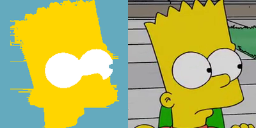

In [ ]:
from google.colab.patches import cv2_imshow
# opencv를 사용할 경우 RGB 색상 형식 대신 BGR 형식으로 이미지 표시
sample_image = cv2.imread("/content/gdrive/MyDrive/study3_simpson/dataset/7024.png",1)
cv2_imshow(sample_image)

In [ ]:
from PIL import Image
import imageio
import numpy as np

def load(sample_image):
  #image = sample_image # image 하나 확인해볼 때!
  
  # 여기 부분은 png 파일들 읽어오기
  image = tf.io.read_file(sample_image)
  image= tf.io.decode_png(sample_image)

  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

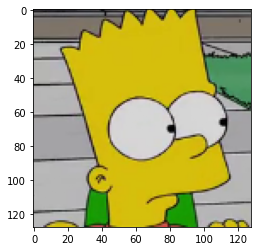

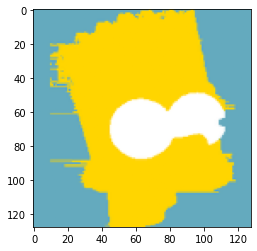

In [ ]:
sample_image = cv2.imread("/content/gdrive/MyDrive/study3_simpson/dataset/7024.png",1)
# BGR -> RGB
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

input, ground_truth = load(sample_image)
input = np.array(input)
ground_truth = np.array(ground_truth)
plt.figure()
plt.imshow(input / 255.0)
plt.figure()
plt.imshow(ground_truth / 255.0)

# Check processing
1. Resize : 128x128 -> 286x286
2. Randomly Crop -> 128*128 (다시)
3. Randomly flip the image horizontally (left to right)
4. normalize the image to the [-1,1] range

In [ ]:
BUFFER_SIZE = 400 # training size
BATCH_SIZE = 1
IMG_WIDTH = 128
IMG_HEIGHT = 128

In [ ]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [ ]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [ ]:
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [ ]:
@tf.function()
def random_jitter(input_image, real_image):
  # 1
  input_image, real_image = resize(input_image, real_image, 140, 140) # 128*128 to larger height, width (140,140)

  # 2. crop 적용 안 하려면 생략
  input_image, real_image = random_crop(input_image, real_image) 

  if tf.random.uniform(()) > 0.5:
    # 3
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

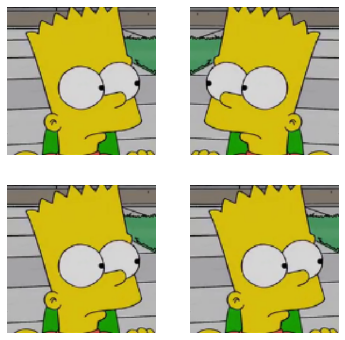

In [ ]:
# crop 생략
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(input, ground_truth)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

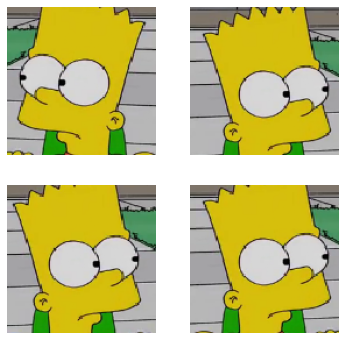

In [ ]:
# random crop 적용
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(input, ground_truth)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

# Define load and preprocess function

In [ ]:
# train dataset
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image) 
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
# test dataset
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

# Build an input pipeline

In [ ]:
all_img_lst = os.listdir(PATH)
all_img_lst[:10]

['7024.png',
 '3583.png',
 '7343.png',
 '2058.png',
 '3236.png',
 '659.png',
 '176.png',
 '2675.png',
 '4159.png',
 '6660.png']

In [ ]:
train_dataset = tf.data.Dataset.list_files(str(PATH + '*.png'))
train_dataset = train_dataset.map(load_image_train, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
# TEST DATASET 도 나중에 만들기

# Build the generator
pix2pix cGan == modified U-Net

### 1) define the downsmapelr (encoder

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
down_model = downsample(3, 4) # filters = 3 =>
down_result = down_model(tf.expand_dims(input, 0)) # 앞에 만든 input 넣어보기
print (down_result.shape) # 반으로 줄어드는 거 확인 since strides = 2

(1, 64, 64, 3)


### 2) define the upsampler (decoder)

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape) # 다시 원래 크기로 복구하면서 filter = 3 으로

(1, 128, 128, 3)


### 3) Define the generator with the downsampler and the upsampler

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[128, 128, 3]) # 2^7

  down_stack = [
    # filter 생각해보기 64 = 2^6 
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 64, 64, 64) 
    downsample(128, 4),  # (batch_size, 32, 32, 128)
    downsample(256, 4),  # (batch_size, 16, 16, 256)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(256, 4),  # (batch_size, 16, 16, 1024)
    upsample(128, 4),  # (batch_size, 32, 32, 512)
    upsample(64, 4),  # (batch_size, 64, 64, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, # output_channels = 3, 이거 왜 1로 하지??
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 128, 128, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

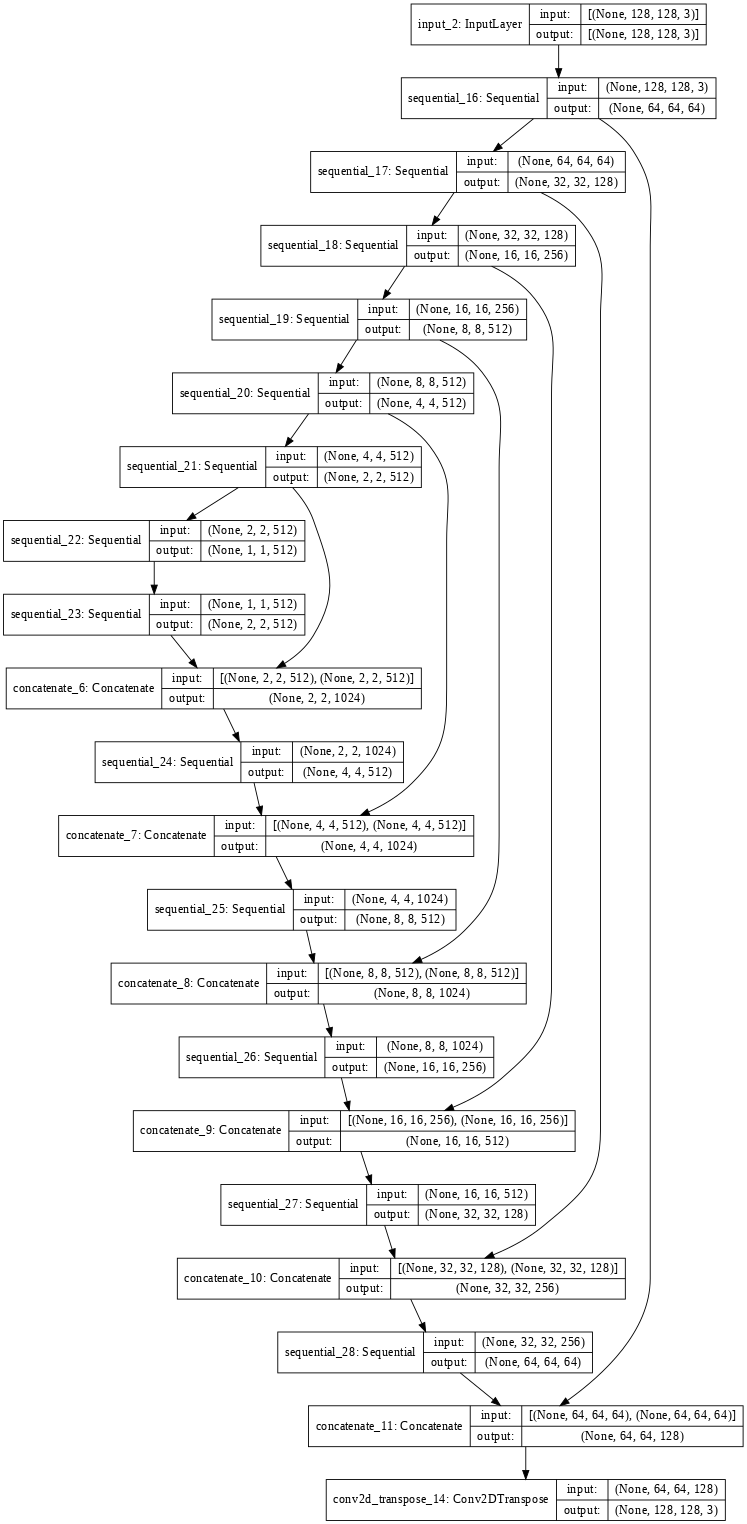

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes = True, dpi=64) # dpi = dots per inch

Test the generator!!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


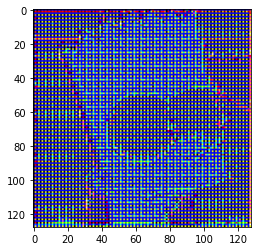

In [ ]:
# tf.newaxis : 기존의 배열을 ... 으로 적고, 추가하고 싶은 위치에 tf.newaxis를 적어주면 size 변경
gen_output = generator(input[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

## 매미인가 ... 무섭다

# Define the generator loss
- generator loss : sigmoid cross-entropy loss of the generated images and an array of ones
- L1 loss = MAE(mean absolute error) b/w the generated image and the target image
- generated image -> -> -> similar to the target image
- calculate the total generator loss : gan_loss + LAMBDA + L1 loss, where LAMBDA=100 (저자가 그냥 정함)

In [ ]:
LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits = True) 
# True로 하면 y_pred = [0,1]

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target-gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

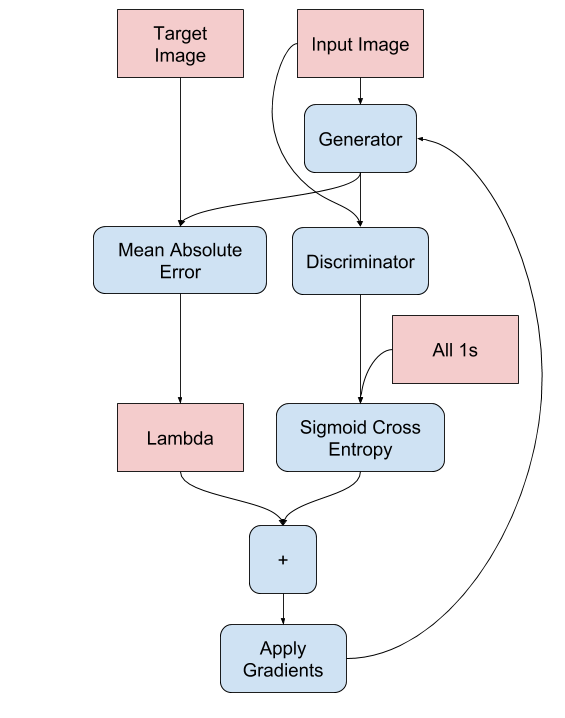

# Build the discriminator
: Discriminator in the pix2pix cGan == convolutional PatchGAN classifier
- each image "patch" is real or not real !!!!
- each block : convolution -> batch normalization -> leaky relu
- ouput = (batch_size, 30, 30, 1) 암튼 이렇게 만들어야 함.
- each 30x30 image patch of the output classifies a 70x70 portion of the input image
- two input
    - (input image, target image)
    - (input image, generated image
    - 'tf.concat([input, target], axis=-1)

# define the discriminator

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[128, 128, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[128, 128, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 128, 128, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 64, 64, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 32, 32, 128)
  #down3 = downsample(256, 4)(down2)  # (batch_size, 16, 16, 256)

  # 30*30으로 만들기 위한 작업들
  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2)  # (batch_size, 34, 34, 128)
  conv = tf.keras.layers.Conv2D(256, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 256)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_Size, 33, 33 , 256)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

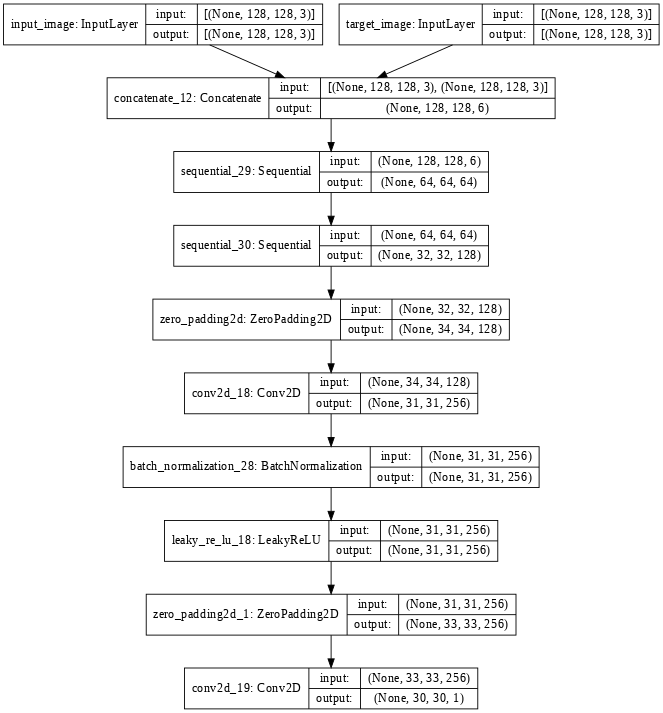

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

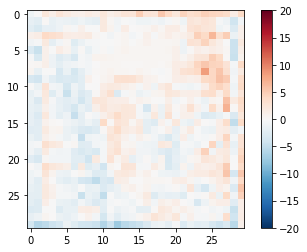

In [ ]:
disc_out = discriminator([input[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

# Define the discriminator loss
- 2 inputs : real images and generated images
- real_loss : sigmoid cross-entropy loss of the real images and an array of ones (real images 니깐!)
- generated loss : sigmoid cross-entropy loss of the generated images and an array of zeros(fake images 니깐!)
- total_loss ==  real_loss + generated_loss

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

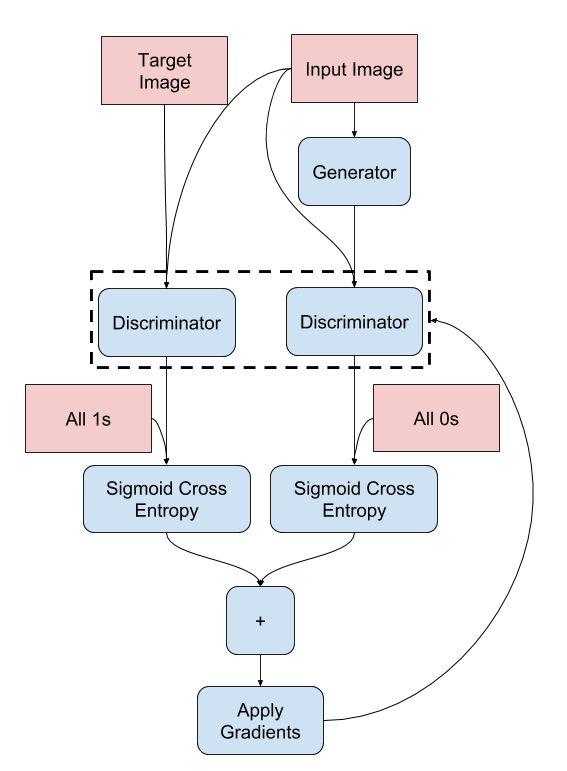

# Define the optimizers and a checkpoint-saver

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Generate Images

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Test the function

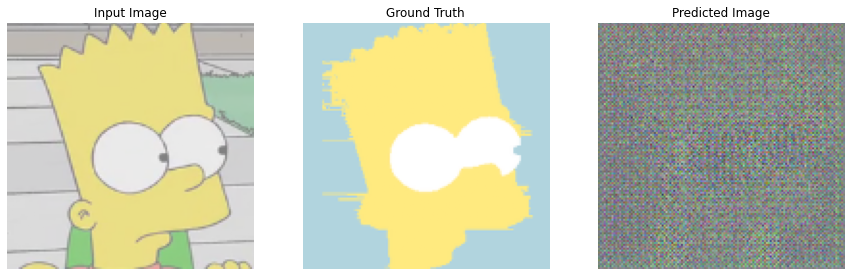

In [ ]:
inp = tf.reshape(input/255.0, shape=[1, 128, 128, 3])
tar = tf.reshape(ground_truth/255.0, shape=[1, 128, 128, 3])
generate_images(generator, inp, tar)

# Training
- each example input generates an output.
- discriminator <- input_image + generated image (as first input)
- discriminator <- input_image + target_image (as second input)
- calculate the generator and the discriminator loss
- calculate the gradients of loss (generator, discriminator) -> apply to optimizer
- log the lossed to tensorboard

In [ ]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [ ]:
def fit(train_ds, test_ds, steps):
  ################ 이 부분 수정!!!!!!!!
  example_input, example_target = next(iter(test_ds.take(1)))

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      start = time.time()
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start} sec\n')

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)